# Hamiltonian Neural Network

### Importing Libraries

In [0]:
!pip install tensorflow==2.0.0-beta

     |████████████████████████████████| 87.9MB 85kB/s 
     |████████████████████████████████| 3.1MB 45.9MB/s 
     |████████████████████████████████| 501kB 56.3MB/s 
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [0]:
import os
import gym
import zipfile
import autograd
import scipy.integrate
solve_ivp  = scipy.integrate.solve_ivp
import autograd.numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlretrieve

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Activation

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

### Data Generation Functions

In [0]:
'''
t_span - time span for data points
timescale - number of datapoints per second
noise_std - standard deviation of the noise (Gaussian Noise)
'''
def get_trajectory(t_span = [0,3], timescale  = 10, y0 = None, noise_std = 0.1, radius = None):
    t_eval = np.linspace(t_span[0], t_span[1], int(timescale*(t_span[1]-t_span[0])))
    if (y0 is None):
        y0 = np.random.rand(2)*2-1
    if radius is None:
      radius = np.random.rand()*0.9 + 1
    y0 = y0/ np.sqrt((y0**2).sum()) * radius

    spring_ivp = solve_ivp(fun = dynamics_fn, t_span = t_span, y0=y0, t_eval=t_eval, rtol=1e-10)
    
    q, p = spring_ivp['y'][0], spring_ivp['y'][1]
    dydt = [dynamics_fn(None, y) for y in spring_ivp['y'].T]
    dydt = np.stack(dydt).T 
    dqdt, dpdt = np.split(dydt,2)
    
    q += np.random.randn(*q.shape)*noise_std
    p += np.random.randn(*p.shape)*noise_std
    return q, p, dqdt, dpdt, t_eval

In [0]:
def get_dataset(samples = 50, test_split = 0.5, radius=1):
    data = {}
    states, dstates = [],  []
    for s in range(samples):
        q, p, dqdt, dpdt, t = get_trajectory(radius=radius)  # states and their derivaties
        states.append( np.stack( [q, p]).T )
        dstates.append( np.stack( [dqdt, dpdt]).T)
    data['states'] = np.concatenate(states)
    data['dstates'] =  np.concatenate(dstates).squeeze()
    
    split_ix = int(len(data['states']) * test_split)
    split_data = {}
    for k in ['states', 'dstates']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

### Model Definitions

Multi Layer Perceptron Model

In [0]:
def MLP(input_dim, hidden_dim, output_dim, nonlinearity='tanh'):
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(hidden_dim, activation=nonlinearity)(inputs)
    x = layers.Dense(hidden_dim, activation=nonlinearity)(x)
    outputs = layers.Dense(output_dim, activation='linear')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
def train_MLP(data, learning_rate = 1e-3, epochs = 200):
    nn_model = MLP(input_dim = data['states'].shape[1], hidden_dim= 200, output_dim=data['dstates'].shape[1], nonlinearity='tanh')
    nn_model.compile(loss='mean_squared_error',optimizer = keras.optimizers.Adam(learning_rate))
    
    nn_model.fit(data['states'], data['dstates'], batch_size=len(data['states']), epochs = epochs)
    return nn_model

In [0]:
def integrate_model_MLP(model, t_span, y0, **kwargs):
    def fun(t, np_x):
        np_x = np_x.reshape((1,2))
        dx = model.predict(np_x)
        return dx
    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

Hamiltonian Neural Network Model

In [0]:
class HNN(keras.Model):
  def __init__(self, input_dim=2):
    super(HNN, self).__init__()
    self.d1 = tf.keras.layers.Dense(200, activation='tanh')
    self.d2 = tf.keras.layers.Dense(200, activation='tanh')
    self.d3 = tf.keras.layers.Dense(1)
    M = np.eye(input_dim)
    M = np.concatenate((M[input_dim//2:], -M[:input_dim//2]), axis=0)
    self.M = tf.constant(M, dtype='double')

  def call(self, x):
    y = self.d1(x)
    y = self.d2(y)
    y = self.d3(y)
    return y

  def forward(self, x):
    with tf.GradientTape() as tape:
        y = self.d1(x)
        y = self.d2(y)
        y = self.d3(y)
    y = tape.gradient(y, x)
    y = y @ self.M
    return y

In [0]:
model = HNN()
print (model.call(tf.Variable([[1.0, 2.0]], dtype='double')))
print (model.forward(tf.Variable([[1.0, 2.0], [1.0, 2.0]], dtype='double')))

tf.Tensor([[-0.00608883]], shape=(1, 1), dtype=float64)
tf.Tensor(
[[0.08816737 0.17858588]
 [0.08816737 0.17858588]], shape=(2, 2), dtype=float64)


In [0]:
def train_HNN(data, learning_rate = 1e-3, epochs = 200):
    model = HNN(input_dim=data['states'].shape[1])
    loss_object = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    for i in range(epochs):
        with tf.GradientTape() as tape1:
            tape1.watch(model.trainable_variables)
            predictions = model.forward(tf.Variable(tf.stack(data['states'])))
            loss = loss_object(tf.Variable(tf.stack(data['dstates'])), predictions)
        gradients = tape1.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        print (i, loss)
    return model

In [0]:
def integrate_model_HNN(model, t_span, y0, **kwargs):
    def fun(t, np_x):
        np_x = tf.Variable(tf.reshape(np_x, (1,2)), dtype='double')
        dx = model.forward(np_x)
        return dx
    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

In [0]:
def integrate_models(x0=np.asarray([1, 0]), t_span=[0,5], t_eval=None, noise_std=0.1):
    # integrate along ground truth vector field
    kwargs = {'t_eval': t_eval, 'rtol': 1e-12}
    true_path = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=x0, **kwargs)
    true_x = true_path['y'].T
    
    # rescale time to compensate for noise effects, as described in appendix
    # t_span[1] *= 1 + .9*noise_std
    # t_eval *= 1 + .9*noise_std

    # integrate along baseline vector field
    hnn_ivp = integrate_model_HNN(hnn_model, t_span, x0, **kwargs)

    base_ivp = integrate_model_MLP(base_model, t_span, x0, **kwargs)
    base_x = base_ivp['y'].T
    # _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)

    # integrate along HNN vector field
    hnn_x = hnn_ivp['y'].T
    # _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)
    
    return true_x, base_x, hnn_x

def energy_loss(true_x, integrated_x):
    true_energy = (true_x**2).sum(1)
    integration_energy = (integrated_x**2).sum(1)
    return np.mean((true_energy - integration_energy)**2)

## Ideal spring-mass system

Defining The Conserved Quantity

In [0]:
def hamiltonian_fn(coords):
  q, p = np.split(coords, 2)
  H = p**2 + q**2
  return H

In [0]:
def dynamics_fn(t, coords):
  dcoords = autograd.grad(hamiltonian_fn)(coords)
  dqdt, dpdt = np.split(dcoords,2)
  S = np.concatenate([dpdt, -dqdt], axis=-1)
  return S

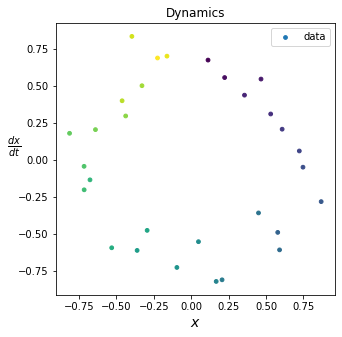

In [0]:
fig = plt.figure(figsize=(5, 5), facecolor='white')
x, y, dx, dy, t = get_trajectory(radius=0.7)
plt.scatter(x,y,c=t,s=14, label='data')

plt.xlabel("$x$", fontsize=14)
plt.ylabel("$\\frac{dx}{dt}$", rotation=0, fontsize=14)
plt.title("Dynamics")
plt.legend(loc='upper right')
plt.show()

Generating Data

In [0]:
data = get_dataset()

Training MLP And HNN Models

In [0]:
base_model = train_MLP(data, epochs=500, learning_rate=0.005)

Train on 750 samples
Epoch 1/500
750/750 [==============================] - 0s 133us/sample - loss: 2.1042
Epoch 2/500
750/750 [==============================] - 0s 14us/sample - loss: 0.3972
Epoch 3/500
750/750 [==============================] - 0s 10us/sample - loss: 0.0798
Epoch 4/500
750/750 [==============================] - 0s 12us/sample - loss: 0.5512
Epoch 5/500
750/750 [==============================] - 0s 15us/sample - loss: 0.6768
Epoch 6/500
750/750 [==============================] - 0s 11us/sample - loss: 0.4432
Epoch 7/500
750/750 [==============================] - 0s 8us/sample - loss: 0.1785
Epoch 8/500
750/750 [==============================] - 0s 9us/sample - loss: 0.0509
Epoch 9/500
750/750 [==============================] - 0s 9us/sample - loss: 0.0646
Epoch 10/500
750/750 [==============================] - 0s 11us/sample - loss: 0.1478
Epoch 11/500
750/750 [==============================] - 0s 15us/sample - loss: 0.2269
Epoch 12/500
750/750 [======================

In [0]:
hnn_model = train_HNN(data, epochs=500, learning_rate=0.005)

0 tf.Tensor(2.0057342052459717, shape=(), dtype=float64)
1 tf.Tensor(3.0613327026367188, shape=(), dtype=float64)
2 tf.Tensor(2.0618724822998047, shape=(), dtype=float64)
3 tf.Tensor(2.1483261585235596, shape=(), dtype=float64)
4 tf.Tensor(2.4181177616119385, shape=(), dtype=float64)
5 tf.Tensor(2.328470468521118, shape=(), dtype=float64)
6 tf.Tensor(2.113696575164795, shape=(), dtype=float64)
7 tf.Tensor(1.977232575416565, shape=(), dtype=float64)
8 tf.Tensor(1.9560805559158325, shape=(), dtype=float64)
9 tf.Tensor(2.0003535747528076, shape=(), dtype=float64)
10 tf.Tensor(2.043358325958252, shape=(), dtype=float64)
11 tf.Tensor(2.0448622703552246, shape=(), dtype=float64)
12 tf.Tensor(2.0043346881866455, shape=(), dtype=float64)
13 tf.Tensor(1.9430491924285889, shape=(), dtype=float64)
14 tf.Tensor(1.8813766241073608, shape=(), dtype=float64)
15 tf.Tensor(1.8281770944595337, shape=(), dtype=float64)
16 tf.Tensor(1.781887412071228, shape=(), dtype=float64)
17 tf.Tensor(1.73589694499969

### Analysis

In [0]:
t_span = [0,30]
y0 = np.array([1, 0])
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 2000), 'rtol': 1e-12}
hnn_ivp = integrate_model_HNN(hnn_model, t_span, y0, **kwargs)
base_ivp = integrate_model_MLP(base_model, t_span, y0, **kwargs)

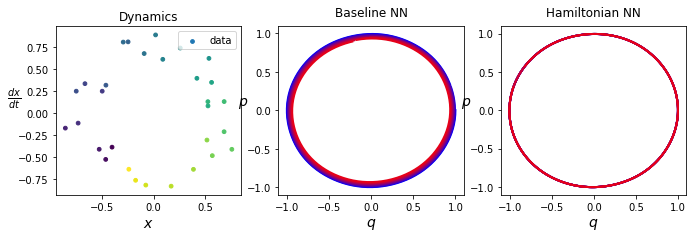

In [0]:
LINE_SEGMENTS = 10
LINE_WIDTH = 2

fig = plt.figure(figsize=(11.3, 3.1), facecolor='white')
fig.add_subplot(1, 3, 1, frameon=True)
x, y, dx, dy, t = get_trajectory(radius=0.7)
plt.scatter(x,y,c=t,s=14, label='data')

plt.xlabel("$x$", fontsize=14)
plt.ylabel("$\\frac{dx}{dt}$", rotation=0, fontsize=14)
plt.title("Dynamics")
plt.legend(loc='upper right')

fig.add_subplot(1, 3, 2, frameon=True)
for i, l in enumerate(np.split(base_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)
    
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Baseline NN", pad=10)

fig.add_subplot(1, 3, 3, frameon=True)
for i, l in enumerate(np.split(hnn_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)
    
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian NN", pad=10)
plt.show()

(2000, 2) (2000, 2) (2000, 2)


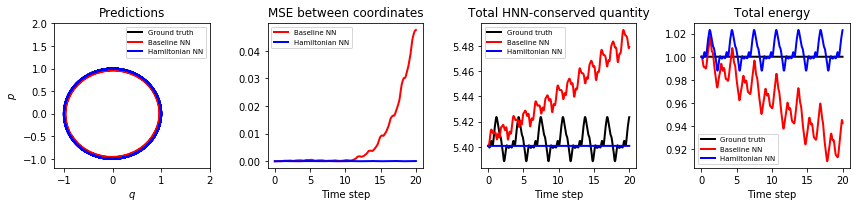

In [0]:
x0 = np.asarray([1, 0])

# integration
t_span=[0,20]
t_eval = np.linspace(t_span[0], t_span[1], 2000)
true_x, base_x, hnn_x = integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)
print (true_x.shape, base_x.shape, hnn_x.shape)

# plotting
tpad = 7

fig = plt.figure(figsize=[12,3])
plt.subplot(1,4,1)
plt.title("Predictions", pad=tpad) ; plt.xlabel('$q$') ; plt.ylabel('$p$')
plt.plot(true_x[:,0], true_x[:,1], 'k-', label='Ground truth', linewidth=2)
plt.plot(base_x[:,0], base_x[:,1], 'r-', label='Baseline NN', linewidth=2)
plt.plot(hnn_x[:,0], hnn_x[:,1], 'b-', label='Hamiltonian NN', linewidth=2)
plt.xlim(-1.2,2) ; plt.ylim(-1.2,2)
plt.legend(fontsize=7)

plt.subplot(1,4,2)
plt.title("MSE between coordinates", pad=tpad) ; plt.xlabel('Time step')
plt.plot(t_eval, ((true_x-base_x)**2).mean(-1), 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, ((true_x-hnn_x)**2).mean(-1), 'b-', label='Hamiltonian NN', linewidth=2)
# print (((true_x-base_x)**2).mean(-1))
# print (((true_x-hnn_x)**2).mean(-1))
plt.legend(fontsize=7)

plt.subplot(1,4,3)
plt.title("Total HNN-conserved quantity", pad=tpad)
plt.xlabel('Time step')
true_hq = hnn_model.call(tf.Variable(true_x))
base_hq = hnn_model.call(tf.Variable(base_x))
hnn_hq = hnn_model.call(tf.Variable(hnn_x))
plt.plot(t_eval, true_hq, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_hq, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, hnn_hq, 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,4,4)
plt.title("Total energy", pad=tpad)
plt.xlabel('Time step')
true_e = np.stack([hamiltonian_fn(c) for c in true_x])
base_e = np.stack([hamiltonian_fn(c) for c in base_x])
hnn_e = np.stack([hamiltonian_fn(c) for c in hnn_x])
plt.plot(t_eval, true_e, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_e, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, hnn_e, 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.tight_layout() ; plt.show()

In [0]:
splits = 5
samples = 3
losses = {'base_energy' : [], 'hnn_energy' : []}
t_eval = np.linspace(t_span[0], t_span[1], 100)

_tmp = [] # for computing batched means
for i in range(splits*samples):
    x0 = np.random.rand(2)*1.6 - .8 # randomly sample a starting px: \in(-2,2) and abs(px) > 0.2
    x0 += 0.2 * np.sign(x0) * np.ones_like(x0)
    true_x, base_x, hnn_x = integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)
    print (true_x.shape, base_x.shape, hnn_x.shape)
    losses['base_energy'] += [ energy_loss(true_x, base_x) ]
    losses['hnn_energy'] += [ energy_loss(true_x, hnn_x) ]
    print('{:.2f}% done'.format(100*float(i)/(splits*samples)), end='\r')

(100, 2) (100, 2) (100, 2)
(100, 2) (100, 2) (100, 2)
(100, 2) (100, 2) (100, 2)
(100, 2) (100, 2) (100, 2)
(100, 2) (100, 2) (100, 2)
(100, 2) (100, 2) (100, 2)
(100, 2) (100, 2) (100, 2)
(100, 2) (100, 2) (100, 2)
(100, 2) (100, 2) (100, 2)
(100, 2) (100, 2) (100, 2)
(100, 2) (100, 2) (100, 2)
(100, 2) (100, 2) (100, 2)
(100, 2) (100, 2) (100, 2)
(100, 2) (100, 2) (100, 2)
(100, 2) (100, 2) (100, 2)


In [0]:
losses = {k: np.array(v) for k,v in losses.items()}
bootstrap_conf = lambda x, splits=5: np.std([np.mean(x_i) for x_i in np.split(x, splits)])/np.sqrt(splits)


print("\nBaseline NN energy MSE: {:.4e} +/- {:.2e}\nHamiltonian NN energy MSE: {:.4e} +/- {:.2e}"
      .format(
          np.mean(losses['base_energy']), bootstrap_conf(losses['base_energy'], splits),
          np.mean(losses['hnn_energy']), bootstrap_conf(losses['hnn_energy'], splits))
     )


Baseline NN energy MSE: 7.7052e-03 +/- 1.99e-03
Hamiltonian NN energy MSE: 1.4886e-04 +/- 2.36e-05


## Ideal Pendulum System

Defining The Conserved Quantity

In [0]:
def hamiltonian_fn(coords):
    q, p = np.split(coords,2)
    H = 3*(1-np.cos(q)) + p**2 # pendulum hamiltonian
    return H

In [0]:
def dynamics_fn(t, coords):
    dcoords = autograd.grad(hamiltonian_fn)(coords)
    dqdt, dpdt = np.split(dcoords,2)
    S = np.concatenate([dpdt, -dqdt], axis=-1)
    return S

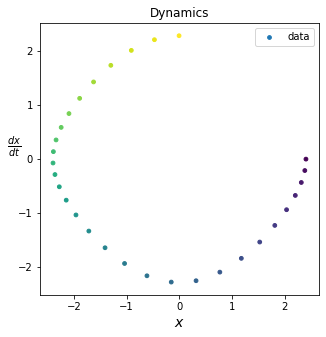

In [0]:
fig = plt.figure(figsize=(5, 5), facecolor='white')
x, y, dx, dy, t = get_trajectory(radius=2.4, y0=np.array([1, 0]), noise_std=0)
plt.scatter(x,y,c=t,s=14, label='data')

plt.xlabel("$x$", fontsize=14)
plt.ylabel("$\\frac{dx}{dt}$", rotation=0, fontsize=14)
plt.title("Dynamics")
plt.legend(loc='upper right')
plt.show()

Generating Data

In [0]:
data = get_dataset(radius=2)

Training MLP And HNN Models

In [0]:
base_model = train_MLP(data, epochs=500, learning_rate=0.005)

Train on 750 samples
Epoch 1/500
750/750 [==============================] - 0s 53us/sample - loss: 7.4036
Epoch 2/500
750/750 [==============================] - 0s 11us/sample - loss: 1.3138
Epoch 3/500
750/750 [==============================] - 0s 11us/sample - loss: 0.4076
Epoch 4/500
750/750 [==============================] - 0s 10us/sample - loss: 1.8981
Epoch 5/500
750/750 [==============================] - 0s 10us/sample - loss: 2.4083
Epoch 6/500
750/750 [==============================] - 0s 10us/sample - loss: 1.7666
Epoch 7/500
750/750 [==============================] - 0s 10us/sample - loss: 0.8687
Epoch 8/500
750/750 [==============================] - 0s 10us/sample - loss: 0.3089
Epoch 9/500
750/750 [==============================] - 0s 10us/sample - loss: 0.2200
Epoch 10/500
750/750 [==============================] - 0s 9us/sample - loss: 0.4325
Epoch 11/500
750/750 [==============================] - 0s 9us/sample - loss: 0.7015
Epoch 12/500
750/750 [======================

In [0]:
hnn_model = train_HNN(data, epochs=500, learning_rate=0.005)

0 tf.Tensor(6.805436134338379, shape=(), dtype=float64)
1 tf.Tensor(7.853639125823975, shape=(), dtype=float64)
2 tf.Tensor(6.823696136474609, shape=(), dtype=float64)
3 tf.Tensor(6.896549701690674, shape=(), dtype=float64)
4 tf.Tensor(7.146612644195557, shape=(), dtype=float64)
5 tf.Tensor(7.013874530792236, shape=(), dtype=float64)
6 tf.Tensor(6.738174915313721, shape=(), dtype=float64)
7 tf.Tensor(6.532688140869141, shape=(), dtype=float64)
8 tf.Tensor(6.4379119873046875, shape=(), dtype=float64)
9 tf.Tensor(6.3871049880981445, shape=(), dtype=float64)
10 tf.Tensor(6.296050548553467, shape=(), dtype=float64)
11 tf.Tensor(6.1212382316589355, shape=(), dtype=float64)
12 tf.Tensor(5.863072872161865, shape=(), dtype=float64)
13 tf.Tensor(5.541940212249756, shape=(), dtype=float64)
14 tf.Tensor(5.1787638664245605, shape=(), dtype=float64)
15 tf.Tensor(4.788026332855225, shape=(), dtype=float64)
16 tf.Tensor(4.379467964172363, shape=(), dtype=float64)
17 tf.Tensor(3.961958408355713, shape

### Analysis

In [0]:
t_span = [0,30]
y0 = np.array([2, 0])
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 2000), 'rtol': 1e-12}
hnn_ivp = integrate_model_HNN(hnn_model, t_span, y0, **kwargs)
base_ivp = integrate_model_MLP(base_model, t_span, y0, **kwargs)

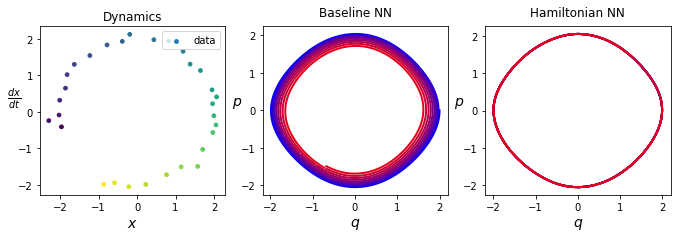

In [0]:
LINE_SEGMENTS = 10
LINE_WIDTH = 2

fig = plt.figure(figsize=(11.3, 3.1), facecolor='white')
fig.add_subplot(1, 3, 1, frameon=True)
x, y, dx, dy, t = get_trajectory(radius=2.0)
plt.scatter(x,y,c=t,s=14, label='data')

plt.xlabel("$x$", fontsize=14)
plt.ylabel("$\\frac{dx}{dt}$", rotation=0, fontsize=14)
plt.title("Dynamics")
plt.legend(loc='upper right')

fig.add_subplot(1, 3, 2, frameon=True)
for i, l in enumerate(np.split(base_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)
    
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Baseline NN", pad=10)

fig.add_subplot(1, 3, 3, frameon=True)
for i, l in enumerate(np.split(hnn_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)
    
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian NN", pad=10)
plt.show()

(2000, 2) (2000, 2) (2000, 2)


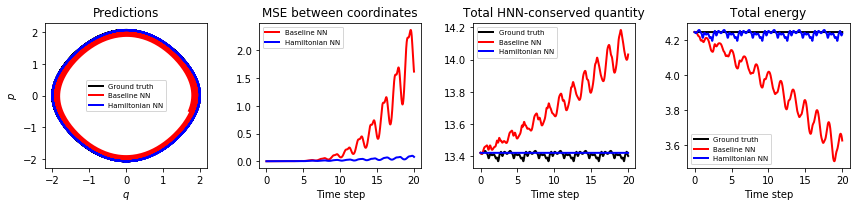

In [0]:
x0 = np.asarray([2, 0])

# integration
t_span=[0,20]
t_eval = np.linspace(t_span[0], t_span[1], 2000)
true_x, base_x, hnn_x = integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)
print (true_x.shape, base_x.shape, hnn_x.shape)

# plotting
tpad = 7

fig = plt.figure(figsize=[12,3])
plt.subplot(1,4,1)
plt.title("Predictions", pad=tpad) ; plt.xlabel('$q$') ; plt.ylabel('$p$')
plt.plot(true_x[:,0], true_x[:,1], 'k-', label='Ground truth', linewidth=2)
plt.plot(base_x[:,0], base_x[:,1], 'r-', label='Baseline NN', linewidth=2)
plt.plot(hnn_x[:,0], hnn_x[:,1], 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,4,2)
plt.title("MSE between coordinates", pad=tpad) ; plt.xlabel('Time step')
plt.plot(t_eval, ((true_x-base_x)**2).mean(-1), 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, ((true_x-hnn_x)**2).mean(-1), 'b-', label='Hamiltonian NN', linewidth=2)
# print (((true_x-base_x)**2).mean(-1))
# print (((true_x-hnn_x)**2).mean(-1))
plt.legend(fontsize=7)

plt.subplot(1,4,3)
plt.title("Total HNN-conserved quantity", pad=tpad)
plt.xlabel('Time step')
true_hq = hnn_model.call(tf.Variable(true_x))
base_hq = hnn_model.call(tf.Variable(base_x))
hnn_hq = hnn_model.call(tf.Variable(hnn_x))
plt.plot(t_eval, true_hq, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_hq, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, hnn_hq, 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,4,4)
plt.title("Total energy", pad=tpad)
plt.xlabel('Time step')
true_e = np.stack([hamiltonian_fn(c) for c in true_x])
base_e = np.stack([hamiltonian_fn(c) for c in base_x])
hnn_e = np.stack([hamiltonian_fn(c) for c in hnn_x])
plt.plot(t_eval, true_e, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_e, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, hnn_e, 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.tight_layout() ; plt.show()

In [0]:
splits = 5
samples = 3
losses = {'base_energy' : [], 'hnn_energy' : []}
t_eval = np.linspace(t_span[0], t_span[1], 100)

_tmp = [] # for computing batched means
for i in range(splits*samples):
    x0 = np.random.rand(2)*1.6 - .8 # randomly sample a starting px: \in(-2,2) and abs(px) > 0.2
    x0 += 0.2 * np.sign(x0) * np.ones_like(x0)
    true_x, base_x, hnn_x = integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)
    print (true_x.shape, base_x.shape, hnn_x.shape)
    losses['base_energy'] += [ energy_loss(true_x, base_x) ]
    losses['hnn_energy'] += [ energy_loss(true_x, hnn_x) ]
    print('{:.2f}% done'.format(100*float(i)/(splits*samples)), end='\r')

(100, 2) (100, 2) (100, 2)
(100, 2) (100, 2) (100, 2)
(100, 2) (100, 2) (100, 2)
(100, 2) (100, 2) (100, 2)
(100, 2) (100, 2) (100, 2)
(100, 2) (100, 2) (100, 2)
(100, 2) (100, 2) (100, 2)
(100, 2) (100, 2) (100, 2)
(100, 2) (100, 2) (100, 2)
(100, 2) (100, 2) (100, 2)
(100, 2) (100, 2) (100, 2)
(100, 2) (100, 2) (100, 2)
(100, 2) (100, 2) (100, 2)
(100, 2) (100, 2) (100, 2)
(100, 2) (100, 2) (100, 2)


In [0]:
losses = {k: np.array(v) for k,v in losses.items()}
bootstrap_conf = lambda x, splits=5: np.std([np.mean(x_i) for x_i in np.split(x, splits)])/np.sqrt(splits)


print("\nBaseline NN energy MSE: {:.4e} +/- {:.2e}\nHamiltonian NN energy MSE: {:.4e} +/- {:.2e}"
      .format(
          np.mean(losses['base_energy']), bootstrap_conf(losses['base_energy'], splits),
          np.mean(losses['hnn_energy']), bootstrap_conf(losses['hnn_energy'], splits))
     )


Baseline NN energy MSE: 3.3086e-01 +/- 6.43e-02
Hamiltonian NN energy MSE: 4.2656e-02 +/- 7.52e-03


## Real Pendulum System

Defining The Conserved Quantity

In [0]:
def hamiltonian_fn(coords):
  k = 2.4  # this coefficient must be fit to the data
  q, p = np.split(coords,2)
  H = k*(1-np.cos(q)) + p**2 # pendulum hamiltonian
  return H

In [0]:
def dynamics_fn(t, coords):
  dcoords = autograd.grad(hamiltonian_fn)(coords)
  dqdt, dpdt = np.split(dcoords,2)
  S = -np.concatenate([dpdt, -dqdt], axis=-1)
  return S

In [0]:
def read_lipson(save_dir):
    experiment_name = 'real_pend_h_1'
    desired_file = experiment_name + ".txt"
    with zipfile.ZipFile('{}/invar_datasets.zip'.format(save_dir)) as z:
        for filename in z.namelist():
            if desired_file == filename and not os.path.isdir(filename):
                with z.open(filename) as f:
                    data = f.read()
    return str(data)


def str2array(string):
  lines = string.split('\\n')
  names = lines[0].strip("b'% \\r").split(' ')
  dnames = ['d' + n for n in names]
  names = ['trial', 't'] + names + dnames
  data = [[float(s) for s in l.strip("' \\r,").split( )] for l in lines[1:-1]]

  return np.asarray(data), names


def get_dataset_real_pend(test_split=0.8):
    save_dir = 'data/real_pend.zip'
    url = 'http://science.sciencemag.org/highwire/filestream/590089/field_highwire_adjunct_files/2/'
    os.makedirs(save_dir) if not os.path.exists(save_dir) else None
    out_file = '{}/invar_datasets.zip'.format(save_dir)
    
    urlretrieve(url, out_file)

    data_str = read_lipson(save_dir)
    state, names = str2array(data_str)

    # put data in a dictionary structure
    data = {k: state[:,i:i+1] for i, k in enumerate(names)}
    data['states'] = state[:,2:4]
    data['dstates'] = (data['states'][1:] - data['states'][:-1]) / (data['t'][1:] - data['t'][:-1])
    data['states'] = data['states'][:-1]

    # make a train/test split while preserving order of data
    # there's no great way to do this.
    # here we just put the test set in the middle of the sequence
    train_set_size = int(len(data['states']) * test_split)
    test_set_size = int(len(data['states']) * (1-test_split))
    test_start_ix = train_set_size#int(train_set_size/2)
    a = test_start_ix
    b = test_start_ix + test_set_size

    split_data = {}
    for k, v in data.items():
        split_data[k] = np.concatenate([v[:a],v[b:]], axis=0)
        split_data['test_' + k] = v[a:b]
    data = split_data
    return data

Generating Data

In [0]:
data = get_dataset_real_pend()

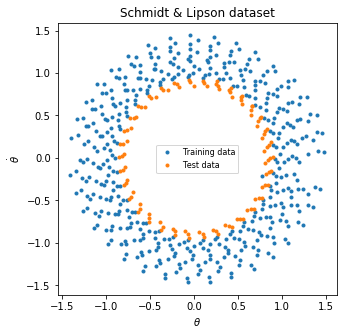

In [0]:
plt.figure(figsize=[5,5])
plt.plot(data['states'][:,0], data['states'][:,1], '.', label='Training data')
plt.plot(data['test_states'][:,0], data['test_states'][:,1], '.', label='Test data')
plt.title('Schmidt & Lipson dataset')
plt.xlabel('$\\theta$') ; plt.ylabel('$\dot \\theta$')
plt.legend(fontsize=8)
plt.show()

Training MLP And HNN Models

In [0]:
base_model = train_MLP(data, epochs=500)

Train on 445 samples
Epoch 1/500
445/445 [==============================] - 0s 101us/sample - loss: 0.5550
Epoch 2/500
445/445 [==============================] - 0s 13us/sample - loss: 0.3071
Epoch 3/500
445/445 [==============================] - 0s 18us/sample - loss: 0.1357
Epoch 4/500
445/445 [==============================] - 0s 15us/sample - loss: 0.0385
Epoch 5/500
445/445 [==============================] - 0s 11us/sample - loss: 0.0068
Epoch 6/500
445/445 [==============================] - 0s 13us/sample - loss: 0.0226
Epoch 7/500
445/445 [==============================] - 0s 14us/sample - loss: 0.0602
Epoch 8/500
445/445 [==============================] - 0s 13us/sample - loss: 0.0947
Epoch 9/500
445/445 [==============================] - 0s 15us/sample - loss: 0.1112
Epoch 10/500
445/445 [==============================] - 0s 11us/sample - loss: 0.1072
Epoch 11/500
445/445 [==============================] - 0s 11us/sample - loss: 0.0882
Epoch 12/500
445/445 [===================

In [0]:
hnn_model = train_HNN(data, epochs=500, learning_rate=0.005)

0 tf.Tensor(0.7900897860527039, shape=(), dtype=float64)
1 tf.Tensor(2.0142805576324463, shape=(), dtype=float64)
2 tf.Tensor(0.8543289303779602, shape=(), dtype=float64)
3 tf.Tensor(0.9470758438110352, shape=(), dtype=float64)
4 tf.Tensor(1.2783758640289307, shape=(), dtype=float64)
5 tf.Tensor(1.1811089515686035, shape=(), dtype=float64)
6 tf.Tensor(0.9211312532424927, shape=(), dtype=float64)
7 tf.Tensor(0.7570770382881165, shape=(), dtype=float64)
8 tf.Tensor(0.7451694011688232, shape=(), dtype=float64)
9 tf.Tensor(0.8157069683074951, shape=(), dtype=float64)
10 tf.Tensor(0.8734822273254395, shape=(), dtype=float64)
11 tf.Tensor(0.8715384602546692, shape=(), dtype=float64)
12 tf.Tensor(0.8201945424079895, shape=(), dtype=float64)
13 tf.Tensor(0.7518296241760254, shape=(), dtype=float64)
14 tf.Tensor(0.6925489902496338, shape=(), dtype=float64)
15 tf.Tensor(0.6531904339790344, shape=(), dtype=float64)
16 tf.Tensor(0.6316938400268555, shape=(), dtype=float64)
17 tf.Tensor(0.619014799

### Analysis

In [0]:
t_span = [0,20]
y0 = np.array([0.75, 0])
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 1000), 'rtol': 1e-12}
base_ivp = integrate_model_MLP(base_model, t_span, y0, **kwargs)
hnn_ivp = integrate_model_HNN(hnn_model, t_span, y0, **kwargs)

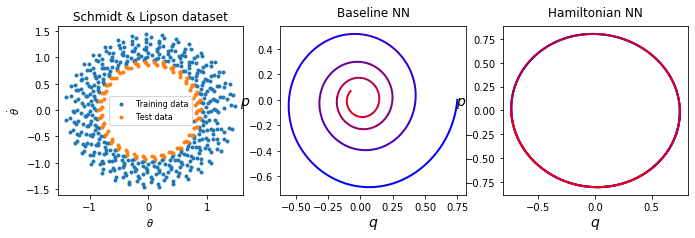

In [0]:
LINE_SEGMENTS = 10
LINE_WIDTH = 2

fig = plt.figure(figsize=(11.3, 3.1), facecolor='white')
fig.add_subplot(1, 3, 1, frameon=True)
data = get_dataset_real_pend()
plt.plot(data['states'][:,0], data['states'][:,1], '.', label='Training data')
plt.plot(data['test_states'][:,0], data['test_states'][:,1], '.', label='Test data')
plt.title('Schmidt & Lipson dataset')
plt.xlabel('$\\theta$') ; plt.ylabel('$\dot \\theta$')
plt.legend(fontsize=8)

fig.add_subplot(1, 3, 2, frameon=True)
for i, l in enumerate(np.split(base_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)
    
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Baseline NN", pad=10)

fig.add_subplot(1, 3, 3, frameon=True)
for i, l in enumerate(np.split(hnn_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)
    
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian NN", pad=10)
plt.show()

In [0]:
t_eval = np.squeeze( data['test_t'] - data['test_t'].min() )
t_span = [t_eval.min(), t_eval.max()]
x0 = data['test_states'][0]
true_x = data['test_states']

# integrate along baseline vector field
base_path = integrate_model_MLP(base_model, t_span, x0, t_eval=t_eval)
base_x = base_path['y'].T

# integrate along HNN vector field
hnn_path = integrate_model_HNN(hnn_model, t_span, x0, t_eval=t_eval)
hnn_x = hnn_path['y'].T

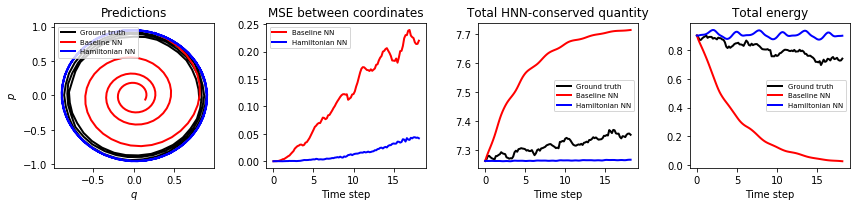

In [0]:
# plotting
tpad = 7

fig = plt.figure(figsize=[12,3])
plt.subplot(1,4,1)
plt.title("Predictions", pad=tpad) ; plt.xlabel('$q$') ; plt.ylabel('$p$')
plt.plot(true_x[:,0], true_x[:,1], 'k-', label='Ground truth', linewidth=2)
plt.plot(base_x[:,0], base_x[:,1], 'r-', label='Baseline NN', linewidth=2)
plt.plot(hnn_x[:,0], hnn_x[:,1], 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,4,2)
plt.title("MSE between coordinates", pad=tpad) ; plt.xlabel('Time step')
plt.plot(t_eval, ((true_x-base_x)**2).mean(-1), 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, ((true_x-hnn_x)**2).mean(-1), 'b-', label='Hamiltonian NN', linewidth=2)
# print (((true_x-base_x)**2).mean(-1))
# print (((true_x-hnn_x)**2).mean(-1))
plt.legend(fontsize=7)

plt.subplot(1,4,3)
plt.title("Total HNN-conserved quantity", pad=tpad)
plt.xlabel('Time step')
true_hq = hnn_model.call(tf.Variable(true_x))
base_hq = hnn_model.call(tf.Variable(base_x))
hnn_hq = hnn_model.call(tf.Variable(hnn_x))
plt.plot(t_eval, true_hq, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_hq, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, hnn_hq, 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,4,4)
plt.title("Total energy", pad=tpad)
plt.xlabel('Time step')
true_e = np.stack([hamiltonian_fn(c) for c in true_x])
base_e = np.stack([hamiltonian_fn(c) for c in base_x])
hnn_e = np.stack([hamiltonian_fn(c) for c in hnn_x])
plt.plot(t_eval, true_e, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_e, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, hnn_e, 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.tight_layout() ; plt.show()

In [0]:
bootstrap_conf = lambda x, splits=5: np.std([np.mean(x_i) for x_i in np.split(x, splits)])/np.sqrt(splits)

def np_L2_dist(x, xhat):
    return (x-xhat)**2

base_distance = np_L2_dist(true_e, base_e)
hnn_distance = np_L2_dist(true_e, hnn_e)

splits = 5
print("\nBaseline NN energy MSE: {:.4e} +/- {:.2e}\nHamiltonian NN energy MSE: {:.4e} +/- {:.2e}"
      .format(
          np.mean(base_distance), bootstrap_conf(base_distance, splits),
          np.mean(hnn_distance), bootstrap_conf(hnn_distance, splits))
     )


Baseline NN energy MSE: 3.4670e-01 +/- 7.20e-02
Hamiltonian NN energy MSE: 1.2575e-02 +/- 4.23e-03


## 2 Body System

Defining The Conserved Quantity

In [0]:
def potential_energy(state):
    tot_energy = np.zeros((1,1,state.shape[2]))
    for i in range(state.shape[0]):
        for j in range(i+1,state.shape[0]):
            r_ij = ((state[i:i+1,1:3] - state[j:j+1,1:3])**2).sum(1, keepdims=True)**.5
            m_i = state[i:i+1,0:1]
            m_j = state[j:j+1,0:1]
    tot_energy += m_i * m_j / r_ij
    U = -tot_energy.sum(0).squeeze()
    return U

def kinetic_energy(state):
    energies = .5 * state[:,0:1] * (state[:,3:5]**2).sum(1, keepdims=True)
    T = energies.sum(0).squeeze()
    return T

def total_energy(state):
    return potential_energy(state) + kinetic_energy(state)

Data Generation Functions - 2 Body System

In [0]:
def get_accelerations(state, epsilon=0):
    # shape of state is [bodies x properties]
    net_accs = [] # [nbodies x 2]
    for i in range(state.shape[0]): # number of bodies
        other_bodies = np.concatenate([state[:i, :], state[i+1:, :]], axis=0)
        displacements = other_bodies[:, 1:3] - state[i, 1:3] # indexes 1:3 -> pxs, pys
        distances = (displacements**2).sum(1, keepdims=True)**0.5
        masses = other_bodies[:, 0:1] # index 0 -> mass
        pointwise_accs = masses * displacements / (distances**3 + epsilon) # G=1
        net_acc = pointwise_accs.sum(0, keepdims=True)
        net_accs.append(net_acc)
    net_accs = np.concatenate(net_accs, axis=0)
    return net_accs
  
def update(t, state):
    state = state.reshape(-1,5) # [bodies, properties]
    deriv = np.zeros_like(state)
    deriv[:,1:3] = state[:,3:5] # dx, dy = vx, vy
    deriv[:,3:5] = get_accelerations(state)
    return deriv.reshape(-1)

In [0]:
def get_orbit(state, update_fn=update, t_points=100, t_span=[0,2], **kwargs):
    if not 'rtol' in kwargs.keys():
        kwargs['rtol'] = 1e-9

    orbit_settings = locals()

    nbodies = state.shape[0]
    t_eval = np.linspace(t_span[0], t_span[1], t_points)
    orbit_settings['t_eval'] = t_eval

    path = solve_ivp(fun=update_fn, t_span=t_span, y0=state.flatten(),
                     t_eval=t_eval, **kwargs)
    orbit = path['y'].reshape(nbodies, 5, t_points)
    return orbit, orbit_settings

In [0]:
def random_config(orbit_noise=5e-2, min_radius=0.5, max_radius=1.5):
    state = np.zeros((2,5))
    state[:,0] = 1
    pos = np.random.rand(2) * (max_radius-min_radius) + min_radius
    r = np.sqrt( np.sum((pos**2)) )

    # velocity that yields a circular orbit
    vel = np.flipud(pos) / (2 * r**1.5)
    vel[0] *= -1
    vel *= 1 + orbit_noise*np.random.randn()

    # make the circular orbits SLIGHTLY elliptical
    state[:,1:3] = pos
    state[:,3:5] = vel
    state[1,1:] *= -1
    return state

In [0]:
def coords2state(coords, nbodies=2, mass=1):
    timesteps = coords.shape[0]
    state = coords.T
    state = state.reshape(-1, nbodies, timesteps).transpose(1,0,2)
    mass_vec = mass * np.ones((nbodies, 1, timesteps))
    state = np.concatenate([mass_vec, state], axis=1)
    return state

In [0]:
def sample_orbits(timesteps=25, trials=500, nbodies=2, orbit_noise=5e-2,
                  min_radius=0.5, max_radius=1.5, t_span=[0, 20], verbose=False, **kwargs):
    
    orbit_settings = locals()
    if verbose:
        print("Making a dataset of near-circular 2-body orbits:")
    
    x, dx, e = [], [], []
    N = timesteps*trials
    while len(x) < N:

        state = random_config(orbit_noise, min_radius, max_radius)
        orbit, settings = get_orbit(state, t_points=timesteps, t_span=t_span, **kwargs)
        batch = orbit.transpose(2,0,1).reshape(-1,10)

        for state in batch:
            dstate = update(None, state)
            
            # reshape from [nbodies, state] where state=[m, qx, qy, px, py]
            # to [canonical_coords] = [qx1, qx2, qy1, qy2, px1,px2,....]
            coords = state.reshape(nbodies,5).T[1:].flatten()
            dcoords = dstate.reshape(nbodies,5).T[1:].flatten()
            x.append(coords)
            dx.append(dcoords)

            shaped_state = state.copy().reshape(2,5,1)
            e.append(total_energy(shaped_state))

    data = {'states': np.stack(x)[:N],
            'dstates': np.stack(dx)[:N],
            'energy': np.stack(e)[:N] }
    return data, orbit_settings

In [0]:
def get_dataset_2body(test_split=0.2, **kwargs):
    data, orbit_settings = sample_orbits(**kwargs)
    
    # make a train/test split
    split_ix = int(data['states'].shape[0] * test_split)
    split_data = {}
    for k, v in data.items():
        split_data[k], split_data['test_' + k] = v[split_ix:], v[:split_ix]
    data = split_data

    data['meta'] = orbit_settings
    return data

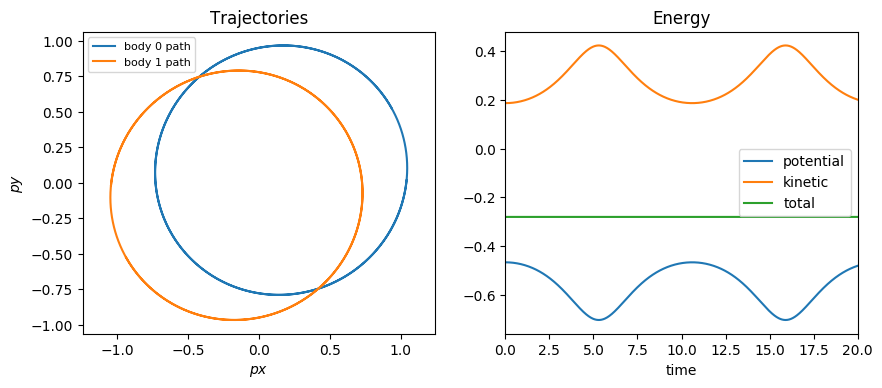

In [0]:
np.random.seed(2)
state = random_config()
orbit, settings = get_orbit(state, t_points=1000, t_span = [0, 20], rtol = 1e-10)

# draw trajectories
fig = plt.figure(figsize=[10,4], dpi=100)
plt.subplot(1,2,1)
plt.title('Trajectories')
for i, path in enumerate(orbit):
    plt.plot(path[1], path[2], label='body {} path'.format(i))

plt.axis('equal')
plt.xlabel('$px$') ; plt.ylabel('$py$')
plt.legend(fontsize=8)

plt.subplot(1,2,2)
plt.title('Energy') ; plt.xlabel('time')
plt.plot(settings['t_eval'], potential_energy(orbit), label='potential')
plt.plot(settings['t_eval'], kinetic_energy(orbit), label='kinetic')
plt.plot(settings['t_eval'], total_energy(orbit), label='total')
plt.legend()
plt.xlim(*settings['t_span'])

plt.show()

Generating Data

In [0]:
data = get_dataset_2body()

In [0]:
print (data['dstates'].shape)

(10000, 8)


Training MLP And HNN Models

In [0]:
base_model = train_MLP(data, epochs=500, learning_rate=0.005)

Train on 10000 samples
Epoch 1/500
10000/10000 [==============================] - 0s 10us/sample - loss: 0.1488
Epoch 2/500
10000/10000 [==============================] - 0s 5us/sample - loss: 0.3131
Epoch 3/500
10000/10000 [==============================] - 0s 6us/sample - loss: 0.1216
Epoch 4/500
10000/10000 [==============================] - 0s 6us/sample - loss: 0.0221
Epoch 5/500
10000/10000 [==============================] - 0s 7us/sample - loss: 0.0624
Epoch 6/500
10000/10000 [==============================] - 0s 6us/sample - loss: 0.1005
Epoch 7/500
10000/10000 [==============================] - 0s 6us/sample - loss: 0.0784
Epoch 8/500
10000/10000 [==============================] - 0s 6us/sample - loss: 0.0335
Epoch 9/500
10000/10000 [==============================] - 0s 6us/sample - loss: 0.0082
Epoch 10/500
10000/10000 [==============================] - 0s 6us/sample - loss: 0.0102
Epoch 11/500
10000/10000 [==============================] - 0s 6us/sample - loss: 0.0232
Epoch 

In [0]:
hnn_model = train_HNN(data, epochs=500, learning_rate=0.005)

0 tf.Tensor(0.05529406666755676, shape=(), dtype=float64)
1 tf.Tensor(0.28711673617362976, shape=(), dtype=float64)
2 tf.Tensor(0.07463515549898148, shape=(), dtype=float64)
3 tf.Tensor(0.08015543222427368, shape=(), dtype=float64)
4 tf.Tensor(0.12154292315244675, shape=(), dtype=float64)
5 tf.Tensor(0.1150435283780098, shape=(), dtype=float64)
6 tf.Tensor(0.08303890377283096, shape=(), dtype=float64)
7 tf.Tensor(0.0556156262755394, shape=(), dtype=float64)
8 tf.Tensor(0.045843061059713364, shape=(), dtype=float64)
9 tf.Tensor(0.052172716706991196, shape=(), dtype=float64)
10 tf.Tensor(0.06218109279870987, shape=(), dtype=float64)
11 tf.Tensor(0.0644722655415535, shape=(), dtype=float64)
12 tf.Tensor(0.058815766125917435, shape=(), dtype=float64)
13 tf.Tensor(0.050420429557561874, shape=(), dtype=float64)
14 tf.Tensor(0.04313364997506142, shape=(), dtype=float64)
15 tf.Tensor(0.03802967071533203, shape=(), dtype=float64)
16 tf.Tensor(0.03476368263363838, shape=(), dtype=float64)
17 tf.

### Analysis

In [0]:
def model_update(t, state, model):
    state = state.reshape(-1,5)

    deriv = np.zeros_like(state)
    np_x = state[:,1:]
    np_x = np_x.T.flatten()[None, :]
    x = tf.constant( np_x, dtype='double')
    dx_hat = model.predict(x)
    deriv[:,1:] = dx_hat.reshape(4,2).T
    return deriv.reshape(-1)


def model_update_HNN(t, state, model):
    state = np.array(state)
    state = state.reshape(-1,5)
    deriv = np.zeros_like(state)
    np_x = state[:,1:]
    np_x = np_x.T.flatten()[None, :]
    x = tf.Variable( np_x, dtype='double')
    dx_hat = np.array(model.forward(x))
    deriv[:,1:] = dx_hat.reshape(4,2).T
    return deriv.reshape(-1)

In [0]:
np.random.seed(2)
t_points = 2000
t_span = [0,50]
state = random_config()

orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span)

update_fn = lambda t, y0: model_update(t, y0, base_model)
base_orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span, update_fn=update_fn)

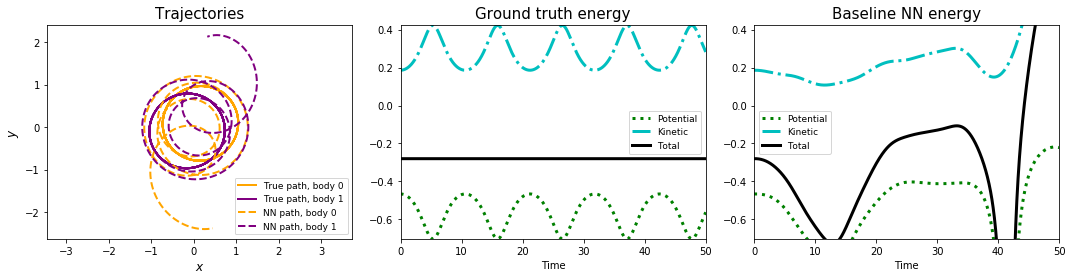

In [0]:
lw = 3 #linewidth
fs=9
ts=15
tpad = 7
ls=12

fig = plt.figure(figsize=[15,4])
plt.subplot(1,3,1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
colors = ['orange', 'purple']
for i, path in enumerate(orbit):
    plt.plot(path[1], path[2], '-', c=colors[i], label='True path, body {}'.format(i), linewidth=2)
    
for i, path in enumerate(base_orbit):
    plt.plot(path[1], path[2], '--', c=colors[i], label='NN path, body {}'.format(i), linewidth=2)

plt.axis('equal')
plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs)

plt.subplot(1,3,2)
real_pe, real_ke, real_etot = potential_energy(orbit), kinetic_energy(orbit), total_energy(orbit)
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], real_pe, 'g:', label='Potential', linewidth=lw)
plt.plot(settings['t_eval'], real_ke, 'c-.', label='Kinetic', linewidth=lw)
plt.plot(settings['t_eval'], real_etot, 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
plt.ylim(ymin, ymax)

plt.subplot(1,3,3)
plt.title('Baseline NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], potential_energy(base_orbit), 'g:', label='Potential', linewidth=lw)
plt.plot(settings['t_eval'], kinetic_energy(base_orbit), 'c-.', label='Kinetic', linewidth=lw)
plt.plot(settings['t_eval'], total_energy(base_orbit), 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
plt.ylim(ymin, ymax)

plt.tight_layout() ; plt.show()

In [0]:
np.random.seed(2)
t_points = 2000
t_span = [0,50]
state = random_config()

orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span)

update_fn = lambda t, y0: model_update_HNN(t, y0, hnn_model)
hnn_orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span, update_fn=update_fn)

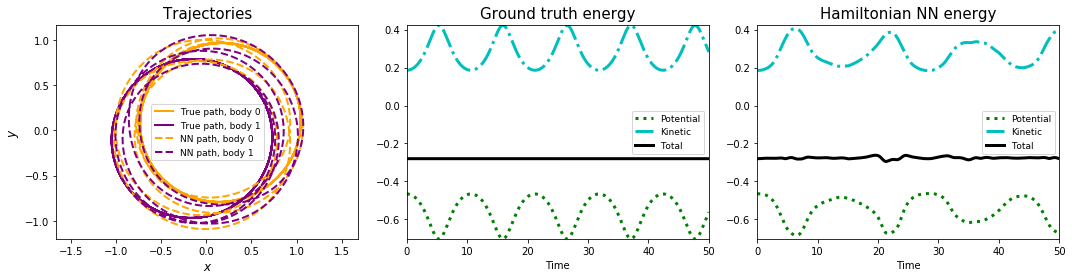

In [0]:
lw = 3 #linewidth
fs=9
ts=15
tpad = 7
ls=12

fig = plt.figure(figsize=[15,4])
plt.subplot(1,3,1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
colors = ['orange', 'purple']
for i, path in enumerate(orbit):
    plt.plot(path[1], path[2], '-', c=colors[i], label='True path, body {}'.format(i), linewidth=2)
    
for i, path in enumerate(hnn_orbit):
    plt.plot(path[1], path[2], '--', c=colors[i], label='NN path, body {}'.format(i), linewidth=2)

plt.axis('equal')
plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs)

plt.subplot(1,3,2)
real_pe, real_ke, real_etot = potential_energy(orbit), kinetic_energy(orbit), total_energy(orbit)
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], real_pe, 'g:', label='Potential', linewidth=lw)
plt.plot(settings['t_eval'], real_ke, 'c-.', label='Kinetic', linewidth=lw)
plt.plot(settings['t_eval'], real_etot, 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
plt.ylim(ymin, ymax)

plt.subplot(1,3,3)
plt.title('Hamiltonian NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], potential_energy(hnn_orbit), 'g:', label='Potential', linewidth=lw)
plt.plot(settings['t_eval'], kinetic_energy(hnn_orbit), 'c-.', label='Kinetic', linewidth=lw)
plt.plot(settings['t_eval'], total_energy(hnn_orbit), 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
plt.ylim(ymin, ymax)

plt.tight_layout() ; plt.show()

In [0]:
def plot_orbits(fig, k, tail=10000, pfrac=0.05, fs=28, ms=40, lw=3, tpad=15):
    xmin = ymin = np.min([orbit[:,1,:].min(), orbit[:,2,:].min()])
    xmax = ymax = np.max([orbit[:,1,:].max(), orbit[:,2,:].max()])
    pad = (xmax-xmin)*pfrac
    xmin -= pad
    xmax += pad
    ymin -= pad
    ymax += pad

    colors = [(0,0,0), (.6,.6,.6)]
    t = max(0, k-tail)

    plt.subplot(1,3,1)
    plt.title('Ground truth', fontsize=fs, pad=tpad)
    for i, path in enumerate(orbit):
        plt.plot(path[1,t:k], path[2,t:k], '--', c=colors[i], linewidth=lw)
        plt.plot(path[1,k], path[2,k], '.', c=colors[i], markersize=ms)
#     plt.axis('off')
#     plt.xticks([], []) ; plt.yticks([], [])
    plt.xlim(xmin, xmax) ; plt.ylim(ymin, ymax)
#     plt.axis('equal')

    colors = [(1,0,0), (1,.6,.6)]
    plt.subplot(1,3,2)
    plt.title('Baseline NN', fontsize=fs, pad=tpad)
    for i, path in enumerate(base_orbit):
        plt.plot(path[1,t:k], path[2,t:k], '--', c=colors[i], linewidth=lw)
        plt.plot(path[1,k], path[2,k], '.', c=colors[i], markersize=ms)
#     plt.axis('off')
#     plt.xticks([], []) ; plt.yticks([], [])
    plt.xlim(xmin, xmax) ; plt.ylim(ymin, ymax)
#     plt.axis('equal')

    colors = [(0,0,1), (.6,.6,1)]
    plt.subplot(1,3,3)
    plt.title('Hamiltonian NN', fontsize=fs, pad=tpad)
    for i, path in enumerate(hnn_orbit):
        plt.plot(path[1,t:k], path[2,t:k], '--', c=colors[i], linewidth=lw)
        plt.plot(path[1,k], path[2,k], '.', c=colors[i], markersize=ms)
#     plt.axis('off')
#     plt.xticks([], []) ; plt.yticks([], [])
    plt.xlim(xmin, xmax) ; plt.ylim(ymin, ymax)
#     plt.axis('equal')
    
    plt.tight_layout()

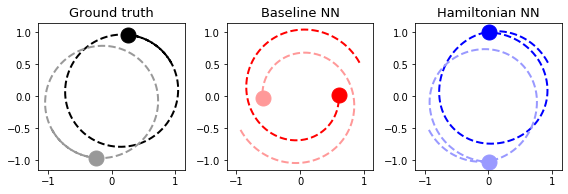

In [0]:
k = 500
fig = plt.figure(figsize=[8,2.8])
plot_orbits(fig, k, fs=13, tpad=6, lw=2, ms=30)
plt.show()

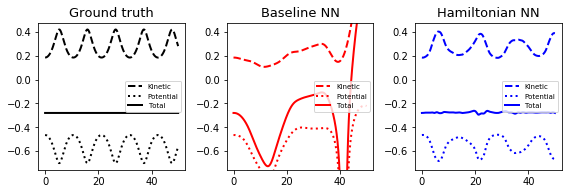

In [0]:
tail=10000; pfrac=0.05
fs=13; tpad=6; lw=2; ms=30

k = 2000
fig = plt.figure(figsize=[8,2.8])

tstart = max(0, k-tail)

real_pe = potential_energy(orbit[...,tstart:k])
real_ke = kinetic_energy(orbit[...,tstart:k])
real_etot = total_energy(orbit[...,tstart:k])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
pad = (ymax-ymin)*pfrac
ymin -= pad
ymax += pad

t = settings['t_eval'][tstart:k]

plt.subplot(1,3,1)
plt.title('Ground truth', fontsize=fs, pad=tpad)
plt.plot(t, real_ke,'k--', linewidth=lw, label='Kinetic')
plt.plot(t, real_pe,'k:', linewidth=lw, label='Potential')
plt.plot(t, real_etot,'k-', linewidth=lw, label='Total')
# plt.xlabel('Time', fontsize=12) #; plt.ylabel("Energy")
plt.ylim(ymin, ymax)
plt.legend(fontsize=7, loc='center right')

plt.subplot(1,3,2)
plt.title('Baseline NN', fontsize=fs, pad=tpad)
plt.plot(t, kinetic_energy(base_orbit[...,tstart:k]), 'r--', linewidth=lw, label='Kinetic')
plt.plot(t, potential_energy(base_orbit[...,tstart:k]), 'r:', linewidth=lw, label='Potential')
plt.plot(t, total_energy(base_orbit[...,tstart:k]), 'r-', linewidth=lw, label='Total')
plt.ylim(ymin, ymax)
# plt.xlabel('Time') ; plt.ylabel("Energy")
plt.legend(fontsize=7, loc='center right')

plt.subplot(1,3,3)
plt.title('Hamiltonian NN', fontsize=fs, pad=tpad)
plt.plot(t, kinetic_energy(hnn_orbit[...,tstart:k]),'b--', linewidth=lw, label='Kinetic')
plt.plot(t, potential_energy(hnn_orbit[...,tstart:k]), 'b:', linewidth=lw, label='Potential')
plt.plot(t, total_energy(hnn_orbit[...,tstart:k]), 'b-', linewidth=lw, label='Total')
plt.ylim(ymin, ymax)
# plt.xlabel('Time') ; plt.ylabel("Energy")
plt.legend(fontsize=7, loc='center right')

plt.tight_layout()

In [0]:
t_points = 500
t_span = [0,25]
trials = 5*3

true_energies, base_energies, hnn_energies = [], [], []
for trial_ix in range(trials):
    
    np.random.seed(trial_ix)
    state = random_config()
    
    # true trajectory -> energy
    orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span)
    true_energies.append(total_energy(orbit))
    
    # baseline NN trajectory -> energy
    update_fn = lambda t, y0: model_update(t, y0, base_model)
    base_orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span, update_fn=update_fn)
    base_energies.append(total_energy(base_orbit))
    
    # hamiltonian NN trajectory -> energy
    update_fn = lambda t, y0: model_update_HNN(t, y0, hnn_model)
    hnn_orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span, update_fn=update_fn)
    hnn_energies.append(total_energy(hnn_orbit))
    
true_energies = np.stack(true_energies)
base_energies = np.stack(base_energies)
hnn_energies = np.stack(hnn_energies)

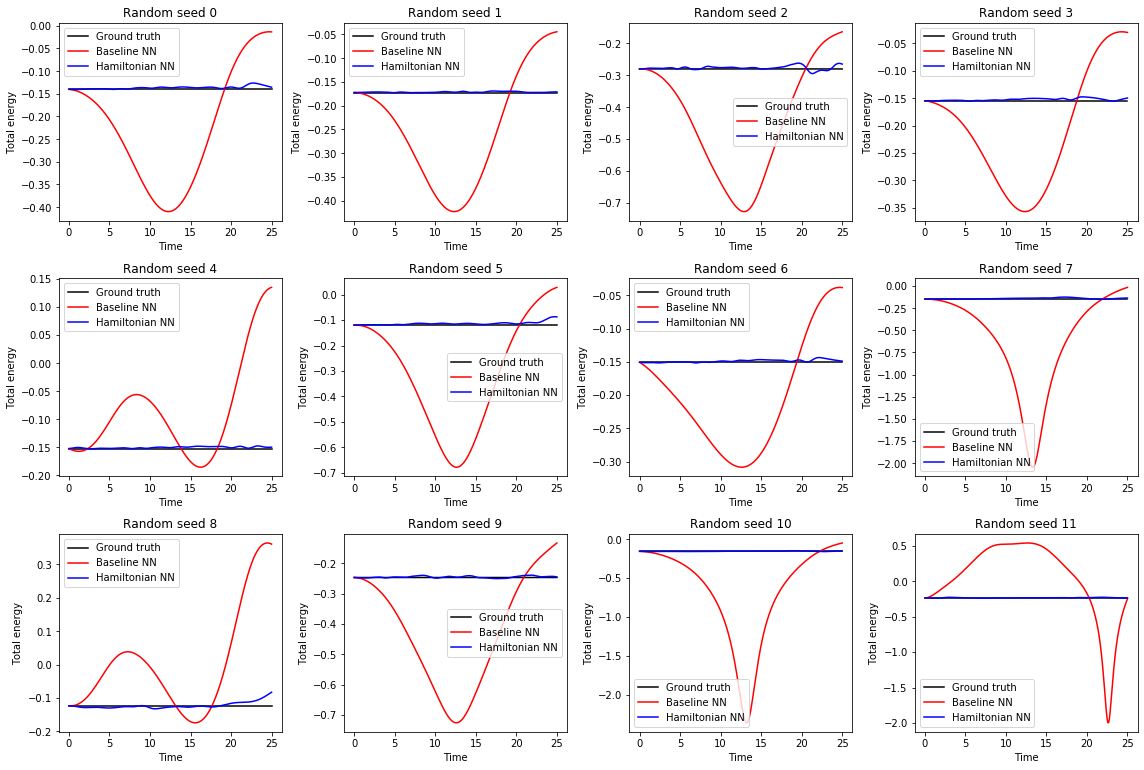

In [0]:
rows, cols = 3, 4
N = rows*cols
s = 4
fig = plt.figure(figsize=[cols*s, .9*rows*s])
for i in range(N):
    
    plt.subplot(rows, cols,i+1)
    t_domain = np.linspace(t_span[0], t_span[1], t_points)
    plt.title('Random seed {}'.format(i))
    plt.plot(t_domain, true_energies[i], 'k-', label='Ground truth')
    plt.plot(t_domain, base_energies[i], 'r-', label='Baseline NN')
    plt.plot(t_domain, hnn_energies[i], 'b-', label='Hamiltonian NN')
    plt.xlabel('Time')
    plt.ylabel('Total energy')
    plt.legend()
    
plt.tight_layout() ; plt.show()

In [0]:
bootstrap_conf = lambda x, splits=5: np.std([np.mean(x_i) for x_i in np.split(x, splits)])/np.sqrt(splits)

def np_L2_dist(x, xhat):
    return (x-xhat)**2

base_distance = np_L2_dist(true_energies, base_energies)
hnn_distance = np_L2_dist(true_energies, hnn_energies)

splits = 5
print("\nBaseline NN energy MSE: {:.4e} +/- {:.2e}\nHamiltonian NN energy MSE: {:.4e} +/- {:.2e}"
      .format(
          np.mean(base_distance), bootstrap_conf(base_distance, splits),
          np.mean(hnn_distance), bootstrap_conf(hnn_distance, splits))
     )


Baseline NN energy MSE: 1.3686e-01 +/- 5.59e-02
Hamiltonian NN energy MSE: 2.8087e-05 +/- 8.76e-06


## 3 Body System

In [0]:
def get_accelerations(state, epsilon=0):
    # shape of state is [bodies x properties]
    net_accs = [] # [nbodies x 2]
    for i in range(state.shape[0]): # number of bodies
        other_bodies = np.concatenate([state[:i, :], state[i+1:, :]], axis=0)
        displacements = other_bodies[:, 1:3] - state[i, 1:3] # indexes 1:3 -> pxs, pys
        distances = (displacements**2).sum(1, keepdims=True)**0.5
        masses = other_bodies[:, 0:1] # index 0 -> mass
        pointwise_accs = masses * displacements / (distances**3 + epsilon) # G=1
        net_acc = pointwise_accs.sum(0, keepdims=True)
        net_accs.append(net_acc)
    net_accs = np.concatenate(net_accs, axis=0)
    return net_accs
  
def update(t, state):
    state = state.reshape(-1,5) # [bodies, properties]
    deriv = np.zeros_like(state)
    deriv[:,1:3] = state[:,3:5] # dx, dy = vx, vy
    deriv[:,3:5] = get_accelerations(state)
    return deriv.reshape(-1)


##### INTEGRATION SETTINGS #####
def get_orbit(state, update_fn=update, t_points=100, t_span=[0,2], nbodies=3, **kwargs):
    if not 'rtol' in kwargs.keys():
        kwargs['rtol'] = 1e-9

    orbit_settings = locals()

    nbodies = state.shape[0]
    t_eval = np.linspace(t_span[0], t_span[1], t_points)
    orbit_settings['t_eval'] = t_eval

    path = solve_ivp(fun=update_fn, t_span=t_span, y0=state.flatten(),
                     t_eval=t_eval, **kwargs)
    orbit = path['y'].reshape(nbodies, 5, t_points)
    return orbit, orbit_settings


##### INITIALIZE THE TWO BODIES #####
def rotate2d(p, theta):
  c, s = np.cos(theta), np.sin(theta)
  R = np.array([[c, -s],[s, c]])
  return (R @ p.reshape(2,1)).squeeze()

def random_config(nu=2e-1, min_radius=0.9, max_radius=1.2):
  '''This is not principled at all yet'''
  state = np.zeros((3,5))
  state[:,0] = 1
  p1 = 2*np.random.rand(2) - 1
  r = np.random.rand() * (max_radius-min_radius) + min_radius
  
  p1 *= r/np.sqrt( np.sum((p1**2)) )
  p2 = rotate2d(p1, theta=2*np.pi/3)
  p3 = rotate2d(p2, theta=2*np.pi/3)

  # # velocity that yields a circular orbit
  v1 = rotate2d(p1, theta=np.pi/2)
  v1 = v1 / r**1.5
  v1 = v1 * np.sqrt(np.sin(np.pi/3)/(2*np.cos(np.pi/6)**2)) # scale factor to get circular trajectories
  v2 = rotate2d(v1, theta=2*np.pi/3)
  v3 = rotate2d(v2, theta=2*np.pi/3)
  
  # make the circular orbits slightly chaotic
  v1 *= 1 + nu*(2*np.random.rand(2) - 1)
  v2 *= 1 + nu*(2*np.random.rand(2) - 1)
  v3 *= 1 + nu*(2*np.random.rand(2) - 1)

  state[0,1:3], state[0,3:5] = p1, v1
  state[1,1:3], state[1,3:5] = p2, v2
  state[2,1:3], state[2,3:5] = p3, v3
  return state


##### INTEGRATE AN ORBIT OR TWO #####
def sample_orbits(timesteps=20, trials=500, nbodies=3, orbit_noise=2e-1,
                  min_radius=0.9, max_radius=1.2, t_span=[0, 20], verbose=False, **kwargs):
    
    orbit_settings = locals()
    if verbose:
        print("Making a dataset of near-circular 3-body orbits:")
    
    x, dx, e = [], [], []
    N = timesteps*trials
    while len(x) < N:

        state = random_config(nu=orbit_noise, min_radius=min_radius, max_radius=max_radius)
        orbit, settings = get_orbit(state, t_points=timesteps, t_span=t_span, nbodies=nbodies, **kwargs)
        batch = orbit.transpose(2,0,1).reshape(-1,nbodies*5)

        for state in batch:
            dstate = update(None, state)
            
            # reshape from [nbodies, state] where state=[m, qx, qy, px, py]
            # to [canonical_coords] = [qx1, qx2, qy1, qy2, px1,px2,....]
            coords = state.reshape(nbodies,5).T[1:].flatten()
            dcoords = dstate.reshape(nbodies,5).T[1:].flatten()
            x.append(coords)
            dx.append(dcoords)

            shaped_state = state.copy().reshape(nbodies,5,1)
            e.append(total_energy(shaped_state))

    data = {'states': np.stack(x)[:N],
            'dstates': np.stack(dx)[:N],
            'energy': np.stack(e)[:N] }
    return data, orbit_settings


##### MAKE A DATASET #####
def make_orbits_dataset(test_split=0.2, **kwargs):
    data, orbit_settings = sample_orbits(**kwargs)
    
    # make a train/test split
    split_ix = int(data['states'].shape[0] * test_split)
    split_data = {}
    for k, v in data.items():
        split_data[k], split_data['test_' + k] = v[split_ix:], v[:split_ix]
    data = split_data

    data['meta'] = orbit_settings
    return data


##### LOAD OR SAVE THE DATASET #####
def get_dataset_3body(**kwargs):
    data = make_orbits_dataset(**kwargs)
    return data

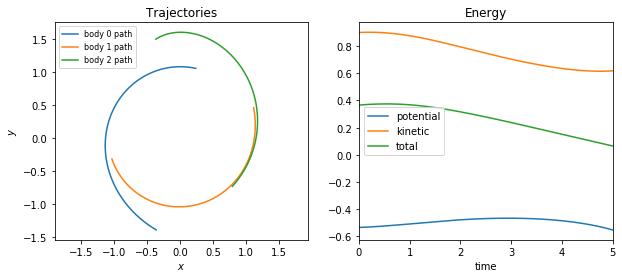

In [0]:
np.random.seed(0)
state = random_config()
orbit, settings = get_orbit(state, t_points=1000, t_span = [0, 5], rtol = 1e-9)

# draw trajectories
fig = plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.title('Trajectories')
for i, path in enumerate(orbit):
    plt.plot(path[1], path[2], label='body {} path'.format(i))

plt.axis('equal')
plt.xlabel('$x$') ; plt.ylabel('$y$')
plt.legend(fontsize=8)

plt.subplot(1,2,2)
plt.title('Energy') ; plt.xlabel('time')
plt.plot(settings['t_eval'], potential_energy(orbit), label='potential')
plt.plot(settings['t_eval'], kinetic_energy(orbit), label='kinetic')
plt.plot(settings['t_eval'], total_energy(orbit), label='total')
plt.legend()
plt.xlim(*settings['t_span'])

plt.show()

In [0]:
data = get_dataset_3body()

In [0]:
base_model = train_MLP(data, epochs=1000, learning_rate=0.005)

Train on 8000 samples
Epoch 1/1000
8000/8000 [==============================] - 0s 11us/sample - loss: 39.6658
Epoch 2/1000
8000/8000 [==============================] - 0s 6us/sample - loss: 38.8508
Epoch 3/1000
8000/8000 [==============================] - 0s 5us/sample - loss: 38.4270
Epoch 4/1000
8000/8000 [==============================] - 0s 7us/sample - loss: 38.0149
Epoch 5/1000
8000/8000 [==============================] - 0s 5us/sample - loss: 37.6415
Epoch 6/1000
8000/8000 [==============================] - 0s 5us/sample - loss: 37.3898
Epoch 7/1000
8000/8000 [==============================] - 0s 5us/sample - loss: 37.2756
Epoch 8/1000
8000/8000 [==============================] - 0s 5us/sample - loss: 37.2375
Epoch 9/1000
8000/8000 [==============================] - 0s 5us/sample - loss: 37.2270
Epoch 10/1000
8000/8000 [==============================] - 0s 5us/sample - loss: 37.2172
Epoch 11/1000
8000/8000 [==============================] - 0s 6us/sample - loss: 37.1832
Epoch 1

In [0]:
hnn_model = train_HNN(data, epochs=1000, learning_rate=0.005)

0 tf.Tensor(39.42412185668945, shape=(), dtype=float64)
1 tf.Tensor(39.47698974609375, shape=(), dtype=float64)
2 tf.Tensor(39.408203125, shape=(), dtype=float64)
3 tf.Tensor(39.39979934692383, shape=(), dtype=float64)
4 tf.Tensor(39.39910888671875, shape=(), dtype=float64)
5 tf.Tensor(39.38932418823242, shape=(), dtype=float64)
6 tf.Tensor(39.376285552978516, shape=(), dtype=float64)
7 tf.Tensor(39.36184310913086, shape=(), dtype=float64)
8 tf.Tensor(39.34721374511719, shape=(), dtype=float64)
9 tf.Tensor(39.33425521850586, shape=(), dtype=float64)
10 tf.Tensor(39.32218933105469, shape=(), dtype=float64)
11 tf.Tensor(39.30714797973633, shape=(), dtype=float64)
12 tf.Tensor(39.28568649291992, shape=(), dtype=float64)
13 tf.Tensor(39.257869720458984, shape=(), dtype=float64)
14 tf.Tensor(39.22682189941406, shape=(), dtype=float64)
15 tf.Tensor(39.195064544677734, shape=(), dtype=float64)
16 tf.Tensor(39.16129684448242, shape=(), dtype=float64)
17 tf.Tensor(39.12079620361328, shape=(), d

In [0]:
def model_update(t, state, model):
    state = state.reshape(-1,5)

    deriv = np.zeros_like(state)
    np_x = state[:,1:]
    np_x = np_x.T.flatten()[None, :]
    x = tf.constant( np_x, dtype='double')
    dx_hat = model.predict(x)
    deriv[:,1:] = dx_hat.reshape(4,3).T
    return deriv.reshape(-1)


def model_update_HNN(t, state, model):
    state = np.array(state)
    state = state.reshape(-1,5)
    deriv = np.zeros_like(state)
    np_x = state[:,1:]
    np_x = np_x.T.flatten()[None, :]
    x = tf.Variable( np_x, dtype='double')
    dx_hat = np.array(model.forward(x))
    deriv[:,1:] = dx_hat.reshape(4,3).T
    return deriv.reshape(-1)

In [0]:
np.random.seed(0)
t_points = 2000
t_span = [0,5]
state = random_config()

orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span)

update_fn = lambda t, y0: model_update(t, y0, base_model)
base_orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span, update_fn=update_fn)

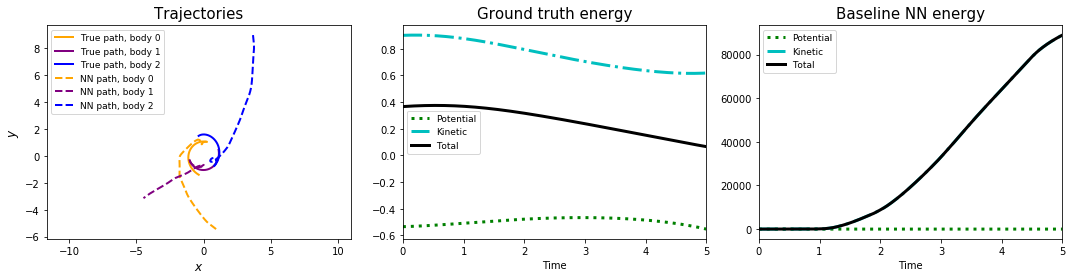

In [0]:
lw = 3 #linewidth
fs=9
ts=15
tpad = 7
ls=12

fig = plt.figure(figsize=[15,4])
plt.subplot(1,3,1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
colors = ['orange', 'purple', 'blue']
for i, path in enumerate(orbit):
    plt.plot(path[1], path[2], '-', c=colors[i], label='True path, body {}'.format(i), linewidth=2)
    
for i, path in enumerate(base_orbit):
    plt.plot(path[1], path[2], '--', c=colors[i], label='NN path, body {}'.format(i), linewidth=2)

plt.axis('equal')
plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs)

plt.subplot(1,3,2)
real_pe, real_ke, real_etot = potential_energy(orbit), kinetic_energy(orbit), total_energy(orbit)
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], real_pe, 'g:', label='Potential', linewidth=lw)
plt.plot(settings['t_eval'], real_ke, 'c-.', label='Kinetic', linewidth=lw)
plt.plot(settings['t_eval'], real_etot, 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])

plt.subplot(1,3,3)
plt.title('Baseline NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], potential_energy(base_orbit), 'g:', label='Potential', linewidth=lw)
plt.plot(settings['t_eval'], kinetic_energy(base_orbit), 'c-.', label='Kinetic', linewidth=lw)
plt.plot(settings['t_eval'], total_energy(base_orbit), 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])

plt.tight_layout() ; plt.show()

In [0]:
np.random.seed(0)
t_points = 2000
t_span = [0,5]
state = random_config()

orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span)

update_fn = lambda t, y0: model_update_HNN(t, y0, hnn_model)
hnn_orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span, update_fn=update_fn)

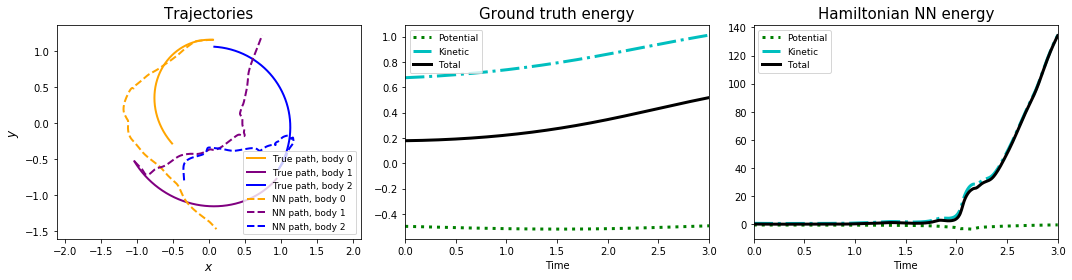

In [0]:
lw = 3 #linewidth
fs=9
ts=15
tpad = 7
ls=12

fig = plt.figure(figsize=[15,4])
plt.subplot(1,3,1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
colors = ['orange', 'purple', 'blue']
for i, path in enumerate(orbit):
    plt.plot(path[1], path[2], '-', c=colors[i], label='True path, body {}'.format(i), linewidth=2)
    
for i, path in enumerate(hnn_orbit):
    plt.plot(path[1], path[2], '--', c=colors[i], label='NN path, body {}'.format(i), linewidth=2)

plt.axis('equal')
plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs)

plt.subplot(1,3,2)
real_pe, real_ke, real_etot = potential_energy(orbit), kinetic_energy(orbit), total_energy(orbit)
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], real_pe, 'g:', label='Potential', linewidth=lw)
plt.plot(settings['t_eval'], real_ke, 'c-.', label='Kinetic', linewidth=lw)
plt.plot(settings['t_eval'], real_etot, 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])

plt.subplot(1,3,3)
plt.title('Hamiltonian NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], potential_energy(hnn_orbit), 'g:', label='Potential', linewidth=lw)
plt.plot(settings['t_eval'], kinetic_energy(hnn_orbit), 'c-.', label='Kinetic', linewidth=lw)
plt.plot(settings['t_eval'], total_energy(hnn_orbit), 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])

plt.tight_layout() ; plt.show()

In [0]:
def plot_orbits(fig, k, tail=10000, pfrac=0.05, fs=28, ms=40, lw=3, tpad=15):
    xmin = ymin = np.min([orbit[:,1,:].min(), orbit[:,2,:].min()])
    xmax = ymax = np.max([orbit[:,1,:].max(), orbit[:,2,:].max()])
    pad = (xmax-xmin)*pfrac
    xmin -= pad
    xmax += pad
    ymin -= pad
    ymax += pad

    colors = [(0,0,0), (.6,.6,.6), (.8,.8,.8)]
    t = max(0, k-tail)

    plt.subplot(1,3,1)
    plt.title('Ground truth', fontsize=fs, pad=tpad)
    for i, path in enumerate(orbit):
        plt.plot(path[1,t:k], path[2,t:k], '--', c=colors[i], linewidth=lw)
    for i, path in enumerate(orbit):
        plt.plot(path[1,k], path[2,k], '.', c=colors[i], markersize=ms)
#     plt.axis('off')
#     plt.xticks([], []) ; plt.yticks([], [])
    plt.xlim(xmin, xmax) ; plt.ylim(ymin, ymax)
#     plt.axis('equal')

    colors = [(1,0,0), (1,.6,.6), (1,.8,.8)]
    plt.subplot(1,3,2)
    plt.title('Baseline NN', fontsize=fs, pad=tpad)
    for i, path in enumerate(base_orbit):
        plt.plot(path[1,t:k], path[2,t:k], '--', c=colors[i], linewidth=lw)
    for i, path in enumerate(base_orbit):
        plt.plot(path[1,k], path[2,k], '.', c=colors[i], markersize=ms)
#     plt.axis('off')
#     plt.xticks([], []) ; plt.yticks([], [])
    plt.xlim(xmin, xmax) ; plt.ylim(ymin, ymax)
#     plt.axis('equal')

    colors = [(0,0,1), (.6,.6,1), (.8,.8,1)]
    plt.subplot(1,3,3)
    plt.title('Hamiltonian NN', fontsize=fs, pad=tpad)
    for i, path in enumerate(hnn_orbit):
        plt.plot(path[1,t:k], path[2,t:k], '--', c=colors[i], linewidth=lw)
    for i, path in enumerate(hnn_orbit):
        plt.plot(path[1,k], path[2,k], '.', c=colors[i], markersize=ms)
#     plt.axis('off')
#     plt.xticks([], []) ; plt.yticks([], [])
    plt.xlim(xmin, xmax) ; plt.ylim(ymin, ymax)
#     plt.axis('equal')
    
    plt.tight_layout()

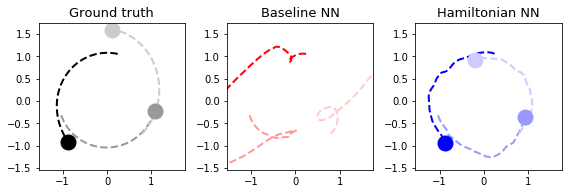

In [0]:
k = 1600
fig = plt.figure(figsize=[8,2.8])
plot_orbits(fig, k, fs=13, tpad=6, lw=2, ms=30)
plt.show()

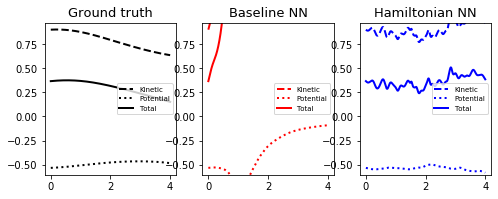

In [0]:
tail=10000; pfrac=0.05
fs=13; tpad=6; lw=2; ms=30

k = 1600
fig = plt.figure(figsize=[8,2.8])

tstart = max(0, k-tail)

real_pe = potential_energy(orbit[...,tstart:k])
real_ke = kinetic_energy(orbit[...,tstart:k])
real_etot = total_energy(orbit[...,tstart:k])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
pad = (ymax-ymin)*pfrac
ymin -= pad
ymax += pad

t = settings['t_eval'][tstart:k]

plt.subplot(1,3,1)
plt.title('Ground truth', fontsize=fs, pad=tpad)
plt.plot(t, real_ke,'k--', linewidth=lw, label='Kinetic')
plt.plot(t, real_pe,'k:', linewidth=lw, label='Potential')
plt.plot(t, real_etot,'k-', linewidth=lw, label='Total')
# plt.xlabel('Time', fontsize=12) #; plt.ylabel("Energy")
plt.ylim(ymin, ymax)
plt.legend(fontsize=7, loc='center right')

plt.subplot(1,3,2)
plt.title('Baseline NN', fontsize=fs, pad=tpad)
plt.plot(t, kinetic_energy(base_orbit[...,tstart:k]), 'r--', linewidth=lw, label='Kinetic')
plt.plot(t, potential_energy(base_orbit[...,tstart:k]), 'r:', linewidth=lw, label='Potential')
plt.plot(t, total_energy(base_orbit[...,tstart:k]), 'r-', linewidth=lw, label='Total')
plt.ylim(ymin, ymax)
# plt.xlabel('Time') ; plt.ylabel("Energy")
plt.legend(fontsize=7, loc='center right')

plt.subplot(1,3,3)
plt.title('Hamiltonian NN', fontsize=fs, pad=tpad)
plt.plot(t, kinetic_energy(hnn_orbit[...,tstart:k]),'b--', linewidth=lw, label='Kinetic')
plt.plot(t, potential_energy(hnn_orbit[...,tstart:k]), 'b:', linewidth=lw, label='Potential')
plt.plot(t, total_energy(hnn_orbit[...,tstart:k]), 'b-', linewidth=lw, label='Total')
plt.ylim(ymin, ymax)
# plt.xlabel('Time') ; plt.ylabel("Energy")
plt.legend(fontsize=7, loc='center right')

In [0]:
t_points = 500
t_span = [0,3]
trials = 15

true_energies, base_energies, hnn_energies = [], [], []
for trial_ix in range(trials):
    
    np.random.seed(trial_ix)
    state = random_config()
    
    # true trajectory -> energy
    orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span)
    true_energies.append(total_energy(orbit))
    
    # baseline NN trajectory -> energy
    update_fn = lambda t, y0: model_update(t, y0, base_model)
    base_orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span, update_fn=update_fn)
    base_energies.append(total_energy(base_orbit))
    
    # hamiltonian NN trajectory -> energy
    update_fn = lambda t, y0: model_update_HNN(t, y0, hnn_model)
    hnn_orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span, update_fn=update_fn)
    hnn_energies.append(total_energy(hnn_orbit))
    
true_energies = np.stack(true_energies)
base_energies = np.stack(base_energies)
hnn_energies = np.stack(hnn_energies)

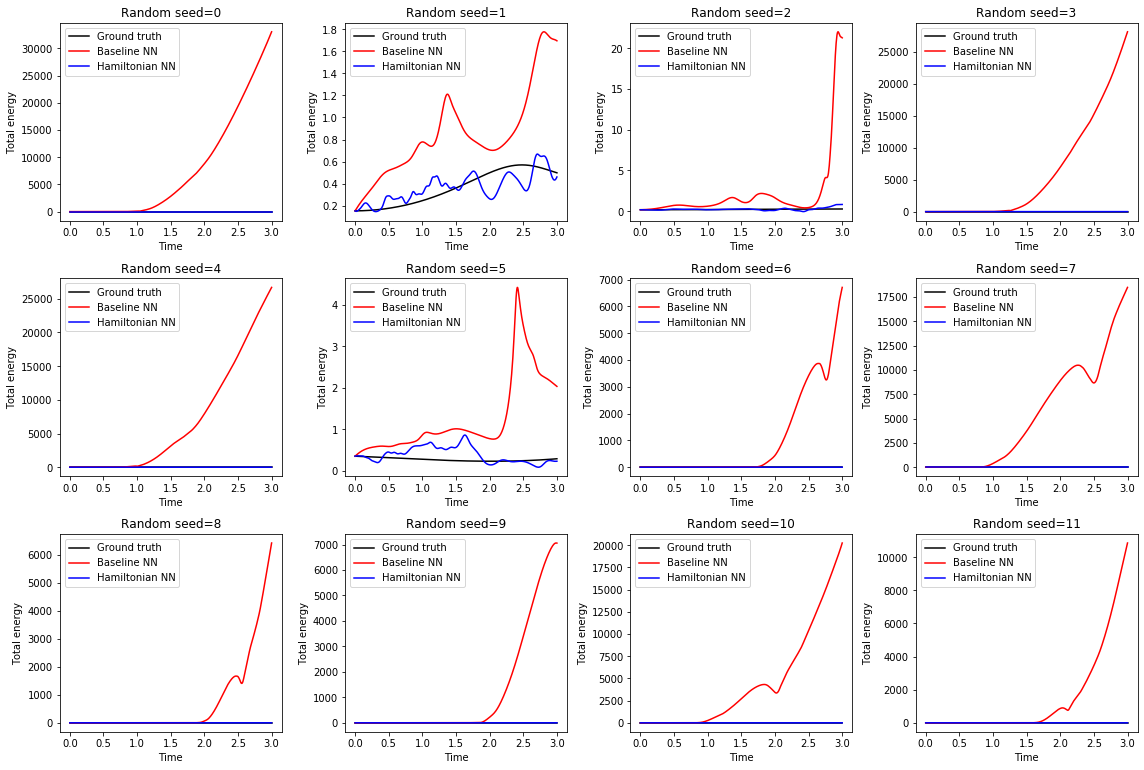

In [0]:
rows, cols = 3, 4
N = rows*cols
s = 4
fig = plt.figure(figsize=[cols*s, .9*rows*s])
for i in range(N):
    
    plt.subplot(rows, cols,i+1)
    t_domain = np.linspace(t_span[0], t_span[1], t_points)
    plt.title('Random seed={}'.format(i))
    plt.plot(t_domain, true_energies[i], 'k-', label='Ground truth')
    plt.plot(t_domain, base_energies[i], 'r-', label='Baseline NN')
    plt.plot(t_domain, hnn_energies[i], 'b-', label='Hamiltonian NN')
    plt.xlabel('Time')
    plt.ylabel('Total energy')
    plt.legend()
    
plt.tight_layout() ; plt.show()

In [0]:
bootstrap_conf = lambda x, splits=5: np.std([np.mean(x_i) for x_i in np.split(x, splits)])/np.sqrt(splits)

def np_L2_dist(x, xhat):
    return (x-xhat)**2

base_distance = np_L2_dist(true_energies, base_energies)
hnn_distance = np_L2_dist(true_energies, hnn_energies)

splits = 5
print("\nBaseline NN energy MSE: {:.4e} +/- {:.2e}\nHamiltonian NN energy MSE: {:.4e} +/- {:.2e}"
      .format(
          np.mean(base_distance), bootstrap_conf(base_distance, splits),
          np.mean(hnn_distance), bootstrap_conf(hnn_distance, splits))
     )


Baseline NN energy MSE: 5.4413e+07 +/- 1.44e+07
Hamiltonian NN energy MSE: 1.0903e+02 +/- 9.75e+01
